## Importing the Dataset

In [37]:
from torchvision import datasets, transforms
import numpy as np
np.random.seed(44)  

transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST (root='data', train=True, transform=transform, download=False)
test_dataset = datasets.FashionMNIST (root='data', train=False, transform=transform, download=False)


Checking properties of the datset

In [38]:
print("Training set size:", len(train_dataset))
print("Test set size:", len(test_dataset))
print("Image size:", train_dataset[0][0].shape) 
print("Number of classes:", len(train_dataset.classes))
print("Class labels:", train_dataset.classes)

Training set size: 60000
Test set size: 10000
Image size: torch.Size([1, 28, 28])
Number of classes: 10
Class labels: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Taking a look at the images

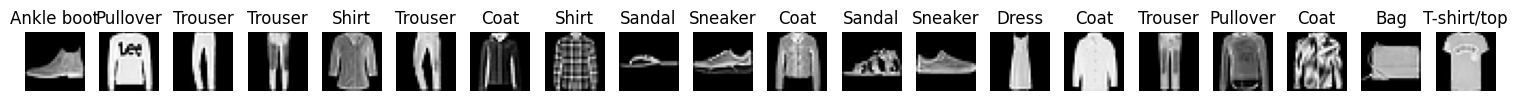

In [39]:
import matplotlib.pyplot as plt

num_samples = 20

samples = [test_dataset[i][0].numpy().squeeze() for i in range(num_samples)]
labels = [test_dataset[i][1] for i in range(num_samples)]

plt.figure(figsize=(15, 1))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(samples[i], cmap="gray")
    plt.title(f"{train_dataset.classes[labels[i]]}") 
    plt.axis("off")

plt.tight_layout()
plt.show()

Processing the dataset

In [40]:
from torch.utils.data import DataLoader, random_split
import torch 

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(68))

train_loader = DataLoader(train_subset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



Defining a base class for Neural layers

In [41]:
class NeuralLayer:
    def __init__(self):
        self.training = True
    
    def train(self):
        self.training = True

    def eval(self):
        self.training = False

Implementation of dense layer

In [42]:
def normal_xavier_init (nY, nX):
    std = (2 / (nX+nY))**0.5
    W = np.random.randn(nY, nX) * std
    return W

class DenseLayer (NeuralLayer):
    pass
    def __init__(self, nX, nY, Adam=True, beta1=0.9, beta2=0.999, epsilon=1e-6):
        super().__init__()
        self.W = normal_xavier_init (nY, nX)
        self.B = np.zeros(nY)

        self.Adam = Adam
        if self.Adam:
            self.beta1 = beta1
            self.beta2 = beta2
            self.epsilon = epsilon
            self.t = 0

            self.m_w = np.ones_like(self.W) * 0.4
            self.m_b = np.zeros_like(self.B)

            self.v_w = np.ones_like(self.W) * 0.16
            self.v_b = np.zeros_like(self.B)

    def forward (self, X_in):
        self.X = X_in
        Y = np.matmul (self.X, np.transpose(self.W)) + self.B
        if np.isnan(Y).any(): 
            print("NaN detected in DenseLayer forward pass")
        return Y
    
    def backward (self, G_y, alpha):
        G_x = np.matmul (G_y, self.W)
        G_w = np.matmul (np.transpose(G_y), self.X)
        G_b = np.sum (G_y, axis=0)

        if self.Adam:   
            self.t = self.t + 1
            self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * G_w
            self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * G_b
            self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * G_w**2
            self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * G_b**2

            m_hat_w = self.m_w / (1 - np.transpose(self.beta1))
            m_hat_b = self.m_b / (1 - np.transpose(self.beta1))
            v_hat_w = self.v_w / (1 - np.transpose(self.beta2))
            v_hat_b = self.v_b / (1 - np.transpose(self.beta2))

            self.W = self.W - alpha * G_w
            self.B = self.B - alpha * G_b

        else:
            self.W = self.W - alpha * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
            self.B = self.B - alpha * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

        if np.isnan(self.W).any() or np.isnan(self.B).any(): 
            print("NaN detected in DenseLayer weights/biases after update")
        
        return G_x
   


Implementation of ReLU Activation function

In [43]:
class ReLU (NeuralLayer):
    pass
    def __init__(self):
        super().__init__()

    def forward (self, X_in):
        self.X = X_in
        return np.maximum (self.X, 0)
    
    def backward (self, G_y, alpha):
        G_x = G_y * (self.X >= 0)
        return G_x

Implementation of Softmax loss function

In [44]:
class Softmax (NeuralLayer):
    pass
    def __init__(self):
        super().__init__()

    def forward (self, X_in):
        self.X = X_in
        shiftX = np.max(self.X, axis=1, keepdims=True)
        numerators = np.exp(self.X- shiftX)
        denominator = np.sum(numerators, axis=1, keepdims=True)
        self.Y = numerators / denominator 
        return self.Y

    def backward (self, Y, alpha):
        G_x = Y
        return G_x


Implementation of Dropout Layer

In [45]:
class Dropout (NeuralLayer):
    pass
    def __init__ (self, probability=0.35):
        super().__init__()
        self.probability = probability
    def forward (self, X):
        if self.training:
            prob_arr = np.random.rand(X.shape[0], X.shape[1])
            self.mask = (prob_arr >= self.probability)
            X_sel_scaled = X * self.mask / (1 - self.probability)
            return X_sel_scaled
        return X 
    
    def backward (self, G_y, alpha):
        G_x = G_y * self.mask / (1 - self.probability)
        return G_x
        

Implementation of Batch Normalisation

In [46]:
class BatchNorm (NeuralLayer):
    pass
    def __init__ (self, N, epsilon=1e-5):
        super().__init__()
        self.N = N
        self.gamma = np.ones(N)*0.5
        self.beta = np.zeros(N)
        self.epsilon = epsilon

    def forward (self, X_in):
        self.X = X_in
        self.mu = np.mean(self.X, axis=0)
        self.var = np.var(self.X, axis=0)
        self.Xhat = (self.X - self.mu) * (self.var + self.epsilon)**(-0.5)
        self.Y = self.gamma * self.Xhat + self.beta
        return self.Y
    
    def backward (self, G_y, alpha):
        G_gamma = np.sum (G_y * self.Xhat, axis=0)
        G_beta = np.sum (G_y, axis=0)
    
        G_Xhat = G_y * self.gamma
        G_x = (self.N * G_Xhat - np.sum(G_Xhat, axis=0) - self.Xhat * np.sum(G_Xhat * self.Xhat, axis=0)) / (self.N * (self.var + self.epsilon)**0.5)
        
        self.gamma = self.gamma - alpha * G_gamma
        self.beta = self.beta - alpha * G_beta

        return G_x

Sequential layer stacking mechanism

In [47]:
class Sequential (NeuralLayer):
    pass
    def __init__ (self, *layers):
        super().__init__()
        self.layers = layers

    def train (self):
        for l in self.layers:
            l.train()

    def eval (self):
        for l in self.layers:
            l.eval()

    def forward (self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward (self, G, alpha):
        for layer in reversed(self.layers):
            G = layer.backward (G, alpha)
        return G


FNN Class-1

In [48]:
class FNN1:
    def __init__(self):
        self.model = Sequential(
            DenseLayer(784, 128),
            BatchNorm(128),
            ReLU(),
            Dropout(0.1),
            DenseLayer(128, 64),
            BatchNorm(64),
            ReLU(),
            Dropout(0.1),
            DenseLayer(64, 10),
            Softmax()
        )

    def train(self):
        self.model.train()

    def eval(self):
        self.model.eval()

    def forward(self, X):
        return self.model.forward(X)

    def backward(self, G_y, alpha):
        return self.model.backward(G_y, alpha)

FFN Class-2

In [49]:
class FNN2:
    def __init__(self):
        self.model = Sequential(
            DenseLayer(784, 256),
            BatchNorm(256),
            ReLU(),
            Dropout(0.1),
            DenseLayer(256, 128),
            BatchNorm(128),
            ReLU(),
            Dropout(0.1),            
            DenseLayer(128, 64),
            BatchNorm(64),
            ReLU(),
            Dropout(0.1),
            DenseLayer(64, 10),
            Softmax()
        )

    def train(self):
        self.model.train()

    def eval(self):
        self.model.eval()

    def forward(self, X):
        return self.model.forward(X)

    def backward(self, G_y, alpha):
        return self.model.backward(G_y, alpha)

FFN Class-3

In [50]:
class FNN3:
    def __init__(self):
        self.model = Sequential(
            DenseLayer(784, 512),
            BatchNorm(512),
            ReLU(),
            Dropout(0.1),
            DenseLayer(512, 256),
            BatchNorm(256),
            ReLU(),
            Dropout(0.1),            
            DenseLayer(256, 128),
            BatchNorm(128),
            ReLU(),
            Dropout(0.1),
            DenseLayer(128, 64),
            BatchNorm(64),
            ReLU(),
            Dropout(0.1),
            DenseLayer(64, 10),
            Softmax()
        )

    def train(self):
        self.model.train()

    def eval(self):
        self.model.eval()

    def forward(self, X):
        return self.model.forward(X)

    def backward(self, G_y, alpha):
        return self.model.backward(G_y, alpha)

Loss Function (Cross-Entropy Loss)

In [51]:
criterion = lambda pred, true: -np.mean(np.sum(true * np.log(pred), axis=1))  # Cross-entropy loss

Training

Epoch 1/10
Training Loss: 0.5414, Training Accuracy: 0.8083, Training Macro-F1 Score: 0.8067
Validation Loss: 0.4059, Validation Accuracy: 0.8519, Validation Macro-F1 Score: 0.8520
Epoch 2/10
Training Loss: 0.4063, Training Accuracy: 0.8524, Training Macro-F1 Score: 0.8515
Validation Loss: 0.3764, Validation Accuracy: 0.8626, Validation Macro-F1 Score: 0.8627
Epoch 3/10
Training Loss: 0.3678, Training Accuracy: 0.8682, Training Macro-F1 Score: 0.8676
Validation Loss: 0.3569, Validation Accuracy: 0.8676, Validation Macro-F1 Score: 0.8679
Epoch 4/10
Training Loss: 0.3410, Training Accuracy: 0.8761, Training Macro-F1 Score: 0.8755
Validation Loss: 0.3480, Validation Accuracy: 0.8720, Validation Macro-F1 Score: 0.8724
Epoch 5/10
Training Loss: 0.3218, Training Accuracy: 0.8825, Training Macro-F1 Score: 0.8821
Validation Loss: 0.3406, Validation Accuracy: 0.8777, Validation Macro-F1 Score: 0.8776
Epoch 6/10
Training Loss: 0.3051, Training Accuracy: 0.8886, Training Macro-F1 Score: 0.8882
Va

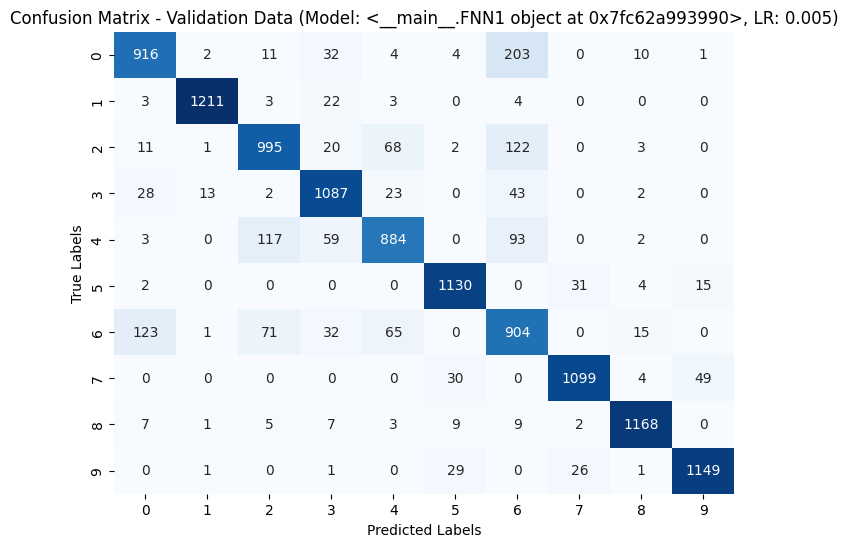

Epoch 1/10
Training Loss: 0.2435, Training Accuracy: 0.9097, Training Macro-F1 Score: 0.9095
Validation Loss: 0.3357, Validation Accuracy: 0.8809, Validation Macro-F1 Score: 0.8813
Epoch 2/10
Training Loss: 0.2341, Training Accuracy: 0.9132, Training Macro-F1 Score: 0.9130
Validation Loss: 0.3336, Validation Accuracy: 0.8852, Validation Macro-F1 Score: 0.8846
Epoch 3/10
Training Loss: 0.2290, Training Accuracy: 0.9143, Training Macro-F1 Score: 0.9140
Validation Loss: 0.3408, Validation Accuracy: 0.8827, Validation Macro-F1 Score: 0.8825
Epoch 4/10
Training Loss: 0.2228, Training Accuracy: 0.9172, Training Macro-F1 Score: 0.9170
Validation Loss: 0.3446, Validation Accuracy: 0.8832, Validation Macro-F1 Score: 0.8834
Epoch 5/10
Training Loss: 0.2182, Training Accuracy: 0.9183, Training Macro-F1 Score: 0.9181
Validation Loss: 0.3448, Validation Accuracy: 0.8816, Validation Macro-F1 Score: 0.8817
Epoch 6/10
Training Loss: 0.2119, Training Accuracy: 0.9195, Training Macro-F1 Score: 0.9193
Va

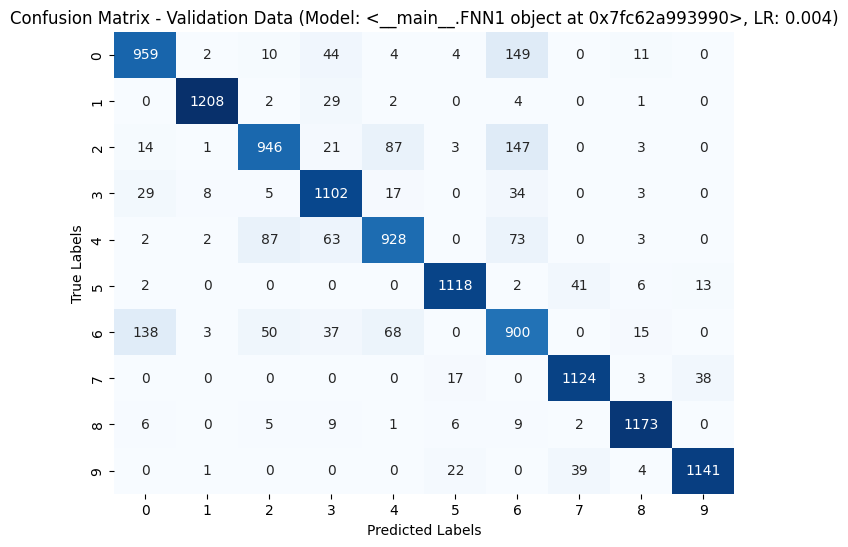

Epoch 1/10
Training Loss: 0.1779, Training Accuracy: 0.9330, Training Macro-F1 Score: 0.9329
Validation Loss: 0.3713, Validation Accuracy: 0.8830, Validation Macro-F1 Score: 0.8832
Epoch 2/10
Training Loss: 0.1736, Training Accuracy: 0.9349, Training Macro-F1 Score: 0.9348
Validation Loss: 0.3757, Validation Accuracy: 0.8826, Validation Macro-F1 Score: 0.8826
Epoch 3/10
Training Loss: 0.1725, Training Accuracy: 0.9346, Training Macro-F1 Score: 0.9346
Validation Loss: 0.3769, Validation Accuracy: 0.8871, Validation Macro-F1 Score: 0.8875
Epoch 4/10
Training Loss: 0.1673, Training Accuracy: 0.9359, Training Macro-F1 Score: 0.9358
Validation Loss: 0.3780, Validation Accuracy: 0.8834, Validation Macro-F1 Score: 0.8838
Epoch 5/10
Training Loss: 0.1621, Training Accuracy: 0.9386, Training Macro-F1 Score: 0.9386
Validation Loss: 0.3860, Validation Accuracy: 0.8856, Validation Macro-F1 Score: 0.8857
Epoch 6/10
Training Loss: 0.1641, Training Accuracy: 0.9371, Training Macro-F1 Score: 0.9370
Va

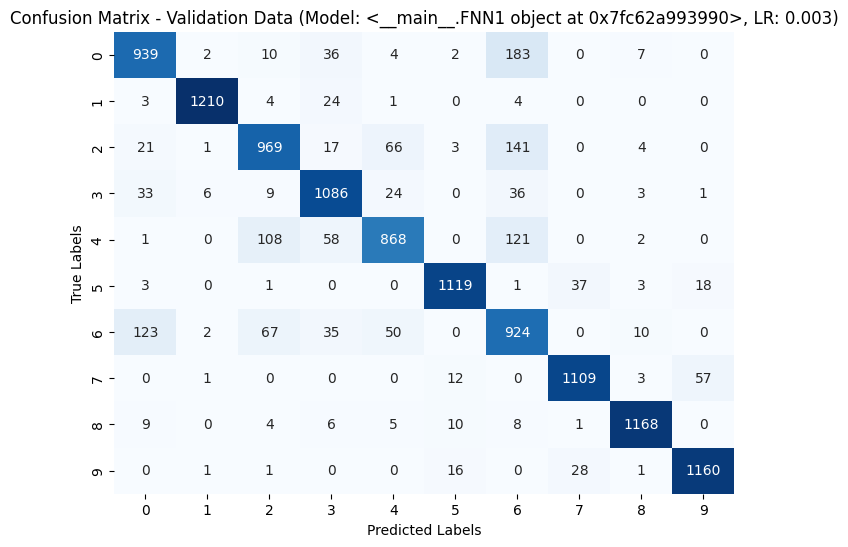

Epoch 1/10
Training Loss: 0.1354, Training Accuracy: 0.9493, Training Macro-F1 Score: 0.9493
Validation Loss: 0.4026, Validation Accuracy: 0.8872, Validation Macro-F1 Score: 0.8872
Epoch 2/10
Training Loss: 0.1301, Training Accuracy: 0.9506, Training Macro-F1 Score: 0.9506
Validation Loss: 0.4140, Validation Accuracy: 0.8880, Validation Macro-F1 Score: 0.8877
Epoch 3/10
Training Loss: 0.1306, Training Accuracy: 0.9504, Training Macro-F1 Score: 0.9504
Validation Loss: 0.4174, Validation Accuracy: 0.8859, Validation Macro-F1 Score: 0.8856
Epoch 4/10
Training Loss: 0.1278, Training Accuracy: 0.9509, Training Macro-F1 Score: 0.9509
Validation Loss: 0.4210, Validation Accuracy: 0.8874, Validation Macro-F1 Score: 0.8868
Epoch 5/10
Training Loss: 0.1223, Training Accuracy: 0.9538, Training Macro-F1 Score: 0.9538
Validation Loss: 0.4249, Validation Accuracy: 0.8842, Validation Macro-F1 Score: 0.8838
Epoch 6/10
Training Loss: 0.1234, Training Accuracy: 0.9528, Training Macro-F1 Score: 0.9528
Va

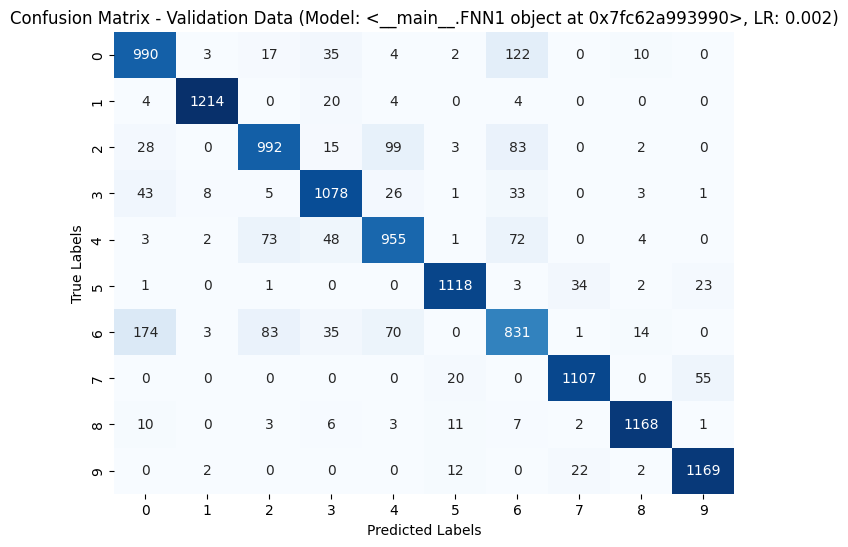

Epoch 1/10
Training Loss: 0.5600, Training Accuracy: 0.8024, Training Macro-F1 Score: 0.8009
Validation Loss: 0.4138, Validation Accuracy: 0.8511, Validation Macro-F1 Score: 0.8505
Epoch 2/10
Training Loss: 0.4256, Training Accuracy: 0.8453, Training Macro-F1 Score: 0.8445
Validation Loss: 0.3841, Validation Accuracy: 0.8593, Validation Macro-F1 Score: 0.8599
Epoch 3/10
Training Loss: 0.3810, Training Accuracy: 0.8625, Training Macro-F1 Score: 0.8619
Validation Loss: 0.3700, Validation Accuracy: 0.8662, Validation Macro-F1 Score: 0.8659
Epoch 4/10
Training Loss: 0.3550, Training Accuracy: 0.8699, Training Macro-F1 Score: 0.8694
Validation Loss: 0.3573, Validation Accuracy: 0.8678, Validation Macro-F1 Score: 0.8680
Epoch 5/10
Training Loss: 0.3351, Training Accuracy: 0.8775, Training Macro-F1 Score: 0.8770
Validation Loss: 0.3500, Validation Accuracy: 0.8724, Validation Macro-F1 Score: 0.8724
Epoch 6/10
Training Loss: 0.3190, Training Accuracy: 0.8827, Training Macro-F1 Score: 0.8822
Va

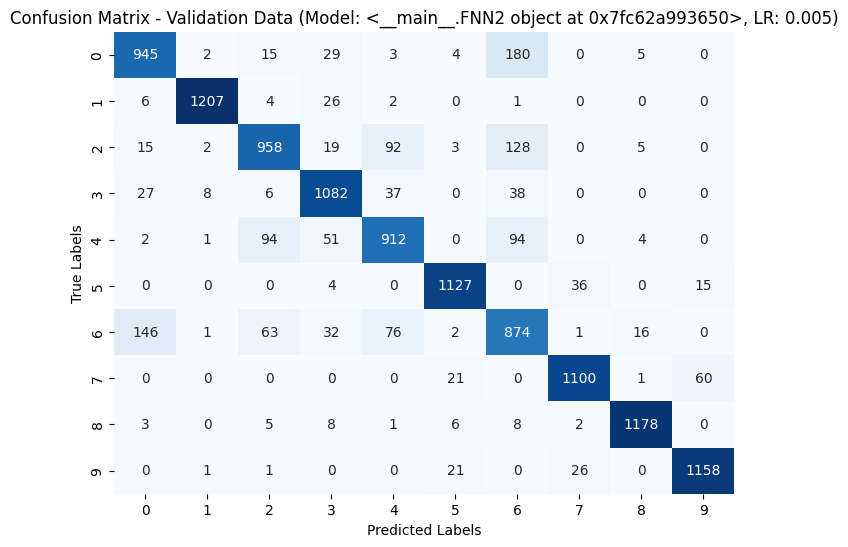

Epoch 1/10
Training Loss: 0.2534, Training Accuracy: 0.9053, Training Macro-F1 Score: 0.9051
Validation Loss: 0.3291, Validation Accuracy: 0.8816, Validation Macro-F1 Score: 0.8815
Epoch 2/10
Training Loss: 0.2458, Training Accuracy: 0.9077, Training Macro-F1 Score: 0.9074
Validation Loss: 0.3361, Validation Accuracy: 0.8811, Validation Macro-F1 Score: 0.8815
Epoch 3/10
Training Loss: 0.2376, Training Accuracy: 0.9112, Training Macro-F1 Score: 0.9110
Validation Loss: 0.3387, Validation Accuracy: 0.8832, Validation Macro-F1 Score: 0.8829
Epoch 4/10
Training Loss: 0.2320, Training Accuracy: 0.9131, Training Macro-F1 Score: 0.9129
Validation Loss: 0.3341, Validation Accuracy: 0.8847, Validation Macro-F1 Score: 0.8846
Epoch 5/10
Training Loss: 0.2255, Training Accuracy: 0.9153, Training Macro-F1 Score: 0.9151
Validation Loss: 0.3339, Validation Accuracy: 0.8858, Validation Macro-F1 Score: 0.8858
Epoch 6/10
Training Loss: 0.2186, Training Accuracy: 0.9178, Training Macro-F1 Score: 0.9175
Va

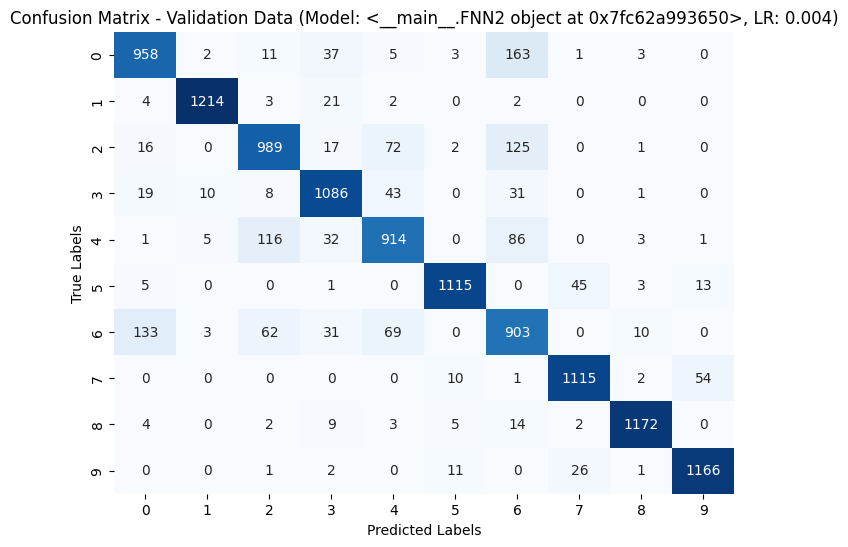

Epoch 1/10
Training Loss: 0.1825, Training Accuracy: 0.9313, Training Macro-F1 Score: 0.9312
Validation Loss: 0.3507, Validation Accuracy: 0.8858, Validation Macro-F1 Score: 0.8861
Epoch 2/10
Training Loss: 0.1810, Training Accuracy: 0.9317, Training Macro-F1 Score: 0.9315
Validation Loss: 0.3521, Validation Accuracy: 0.8885, Validation Macro-F1 Score: 0.8885
Epoch 3/10
Training Loss: 0.1755, Training Accuracy: 0.9332, Training Macro-F1 Score: 0.9331
Validation Loss: 0.3587, Validation Accuracy: 0.8869, Validation Macro-F1 Score: 0.8868
Epoch 4/10
Training Loss: 0.1690, Training Accuracy: 0.9376, Training Macro-F1 Score: 0.9375
Validation Loss: 0.3560, Validation Accuracy: 0.8916, Validation Macro-F1 Score: 0.8915
Epoch 5/10
Training Loss: 0.1663, Training Accuracy: 0.9368, Training Macro-F1 Score: 0.9366
Validation Loss: 0.3625, Validation Accuracy: 0.8901, Validation Macro-F1 Score: 0.8900
Epoch 6/10
Training Loss: 0.1626, Training Accuracy: 0.9384, Training Macro-F1 Score: 0.9382
Va

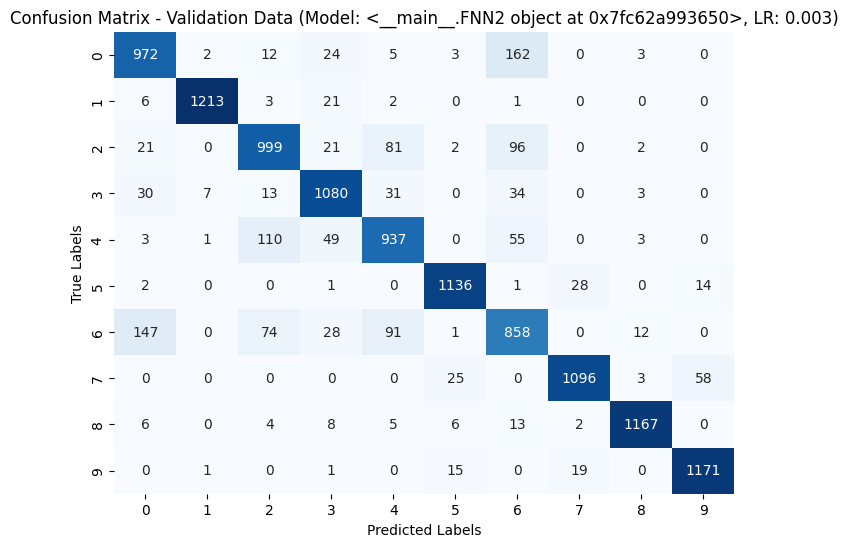

Epoch 1/10
Training Loss: 0.1378, Training Accuracy: 0.9471, Training Macro-F1 Score: 0.9471
Validation Loss: 0.3892, Validation Accuracy: 0.8888, Validation Macro-F1 Score: 0.8884
Epoch 2/10
Training Loss: 0.1322, Training Accuracy: 0.9494, Training Macro-F1 Score: 0.9494
Validation Loss: 0.3896, Validation Accuracy: 0.8918, Validation Macro-F1 Score: 0.8918
Epoch 3/10
Training Loss: 0.1262, Training Accuracy: 0.9535, Training Macro-F1 Score: 0.9534
Validation Loss: 0.3965, Validation Accuracy: 0.8898, Validation Macro-F1 Score: 0.8899
Epoch 4/10
Training Loss: 0.1264, Training Accuracy: 0.9526, Training Macro-F1 Score: 0.9525
Validation Loss: 0.4089, Validation Accuracy: 0.8891, Validation Macro-F1 Score: 0.8892
Epoch 5/10
Training Loss: 0.1256, Training Accuracy: 0.9524, Training Macro-F1 Score: 0.9523
Validation Loss: 0.4039, Validation Accuracy: 0.8916, Validation Macro-F1 Score: 0.8916
Epoch 6/10
Training Loss: 0.1178, Training Accuracy: 0.9558, Training Macro-F1 Score: 0.9557
Va

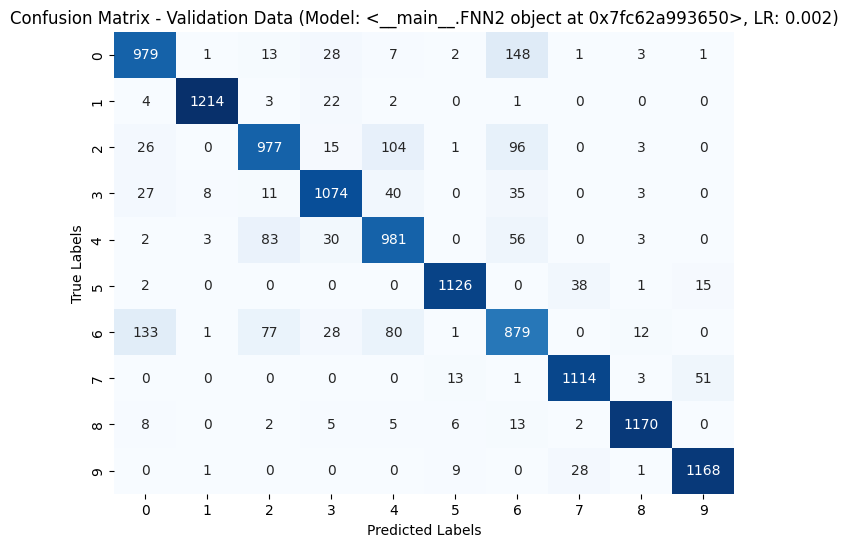

Epoch 1/10
Training Loss: 0.5754, Training Accuracy: 0.7964, Training Macro-F1 Score: 0.7944
Validation Loss: 0.4356, Validation Accuracy: 0.8436, Validation Macro-F1 Score: 0.8435
Epoch 2/10
Training Loss: 0.4345, Training Accuracy: 0.8422, Training Macro-F1 Score: 0.8412
Validation Loss: 0.3941, Validation Accuracy: 0.8577, Validation Macro-F1 Score: 0.8575
Epoch 3/10
Training Loss: 0.3992, Training Accuracy: 0.8554, Training Macro-F1 Score: 0.8548
Validation Loss: 0.3873, Validation Accuracy: 0.8593, Validation Macro-F1 Score: 0.8598
Epoch 4/10
Training Loss: 0.3714, Training Accuracy: 0.8642, Training Macro-F1 Score: 0.8635
Validation Loss: 0.3764, Validation Accuracy: 0.8611, Validation Macro-F1 Score: 0.8620
Epoch 5/10
Training Loss: 0.3529, Training Accuracy: 0.8711, Training Macro-F1 Score: 0.8705
Validation Loss: 0.3646, Validation Accuracy: 0.8708, Validation Macro-F1 Score: 0.8709
Epoch 6/10
Training Loss: 0.3322, Training Accuracy: 0.8779, Training Macro-F1 Score: 0.8775
Va

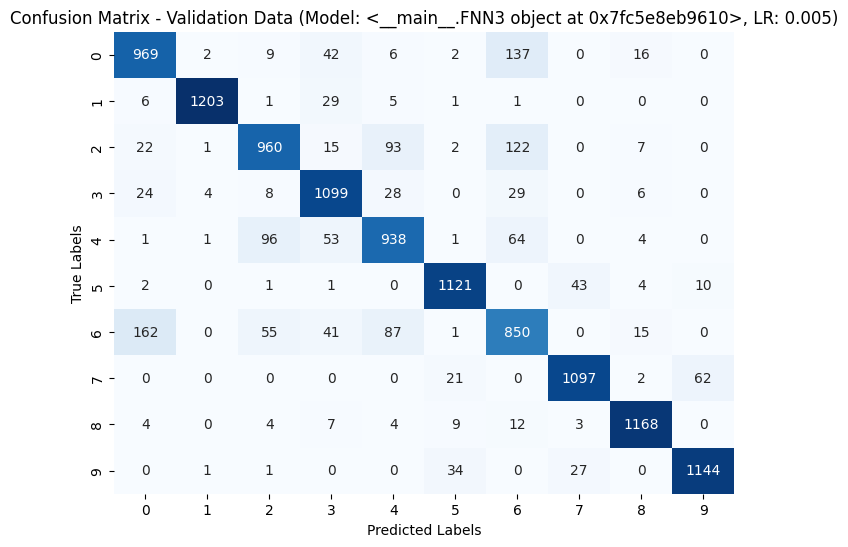

Epoch 1/10
Training Loss: 0.2632, Training Accuracy: 0.9019, Training Macro-F1 Score: 0.9016
Validation Loss: 0.3330, Validation Accuracy: 0.8839, Validation Macro-F1 Score: 0.8838
Epoch 2/10
Training Loss: 0.2522, Training Accuracy: 0.9054, Training Macro-F1 Score: 0.9052
Validation Loss: 0.3326, Validation Accuracy: 0.8836, Validation Macro-F1 Score: 0.8833
Epoch 3/10
Training Loss: 0.2461, Training Accuracy: 0.9076, Training Macro-F1 Score: 0.9072
Validation Loss: 0.3363, Validation Accuracy: 0.8844, Validation Macro-F1 Score: 0.8843
Epoch 4/10
Training Loss: 0.2367, Training Accuracy: 0.9117, Training Macro-F1 Score: 0.9114
Validation Loss: 0.3433, Validation Accuracy: 0.8806, Validation Macro-F1 Score: 0.8807
Epoch 5/10
Training Loss: 0.2322, Training Accuracy: 0.9127, Training Macro-F1 Score: 0.9125
Validation Loss: 0.3454, Validation Accuracy: 0.8813, Validation Macro-F1 Score: 0.8811
Epoch 6/10
Training Loss: 0.2260, Training Accuracy: 0.9145, Training Macro-F1 Score: 0.9143
Va

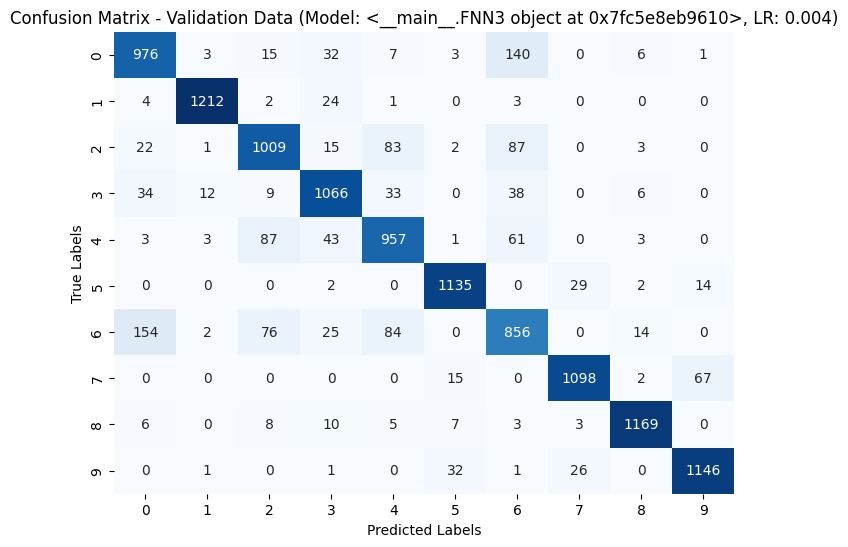

Epoch 1/10
Training Loss: 0.1858, Training Accuracy: 0.9293, Training Macro-F1 Score: 0.9292
Validation Loss: 0.3526, Validation Accuracy: 0.8882, Validation Macro-F1 Score: 0.8878
Epoch 2/10
Training Loss: 0.1782, Training Accuracy: 0.9317, Training Macro-F1 Score: 0.9316
Validation Loss: 0.3518, Validation Accuracy: 0.8882, Validation Macro-F1 Score: 0.8877
Epoch 3/10
Training Loss: 0.1748, Training Accuracy: 0.9347, Training Macro-F1 Score: 0.9346
Validation Loss: 0.3579, Validation Accuracy: 0.8861, Validation Macro-F1 Score: 0.8858
Epoch 4/10
Training Loss: 0.1697, Training Accuracy: 0.9359, Training Macro-F1 Score: 0.9358
Validation Loss: 0.3692, Validation Accuracy: 0.8867, Validation Macro-F1 Score: 0.8863
Epoch 5/10
Training Loss: 0.1652, Training Accuracy: 0.9374, Training Macro-F1 Score: 0.9373
Validation Loss: 0.3683, Validation Accuracy: 0.8872, Validation Macro-F1 Score: 0.8872
Epoch 6/10
Training Loss: 0.1615, Training Accuracy: 0.9400, Training Macro-F1 Score: 0.9399
Va

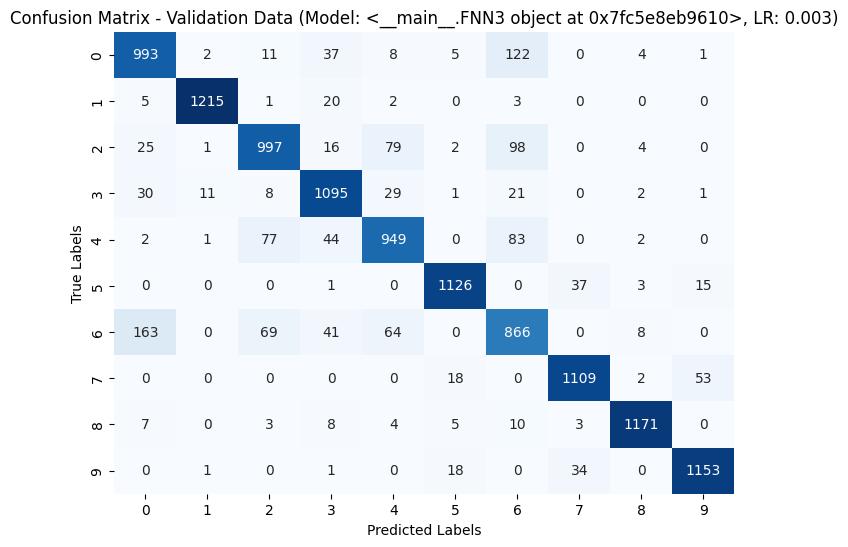

Epoch 1/10
Training Loss: 0.1299, Training Accuracy: 0.9509, Training Macro-F1 Score: 0.9508
Validation Loss: 0.3981, Validation Accuracy: 0.8882, Validation Macro-F1 Score: 0.8879
Epoch 2/10
Training Loss: 0.1249, Training Accuracy: 0.9523, Training Macro-F1 Score: 0.9523
Validation Loss: 0.4010, Validation Accuracy: 0.8876, Validation Macro-F1 Score: 0.8874
Epoch 3/10
Training Loss: 0.1225, Training Accuracy: 0.9535, Training Macro-F1 Score: 0.9535
Validation Loss: 0.4054, Validation Accuracy: 0.8911, Validation Macro-F1 Score: 0.8908
Epoch 4/10
Training Loss: 0.1153, Training Accuracy: 0.9566, Training Macro-F1 Score: 0.9566
Validation Loss: 0.4261, Validation Accuracy: 0.8870, Validation Macro-F1 Score: 0.8867
Epoch 5/10
Training Loss: 0.1164, Training Accuracy: 0.9559, Training Macro-F1 Score: 0.9559
Validation Loss: 0.4193, Validation Accuracy: 0.8882, Validation Macro-F1 Score: 0.8878
Epoch 6/10
Training Loss: 0.1170, Training Accuracy: 0.9554, Training Macro-F1 Score: 0.9553
Va

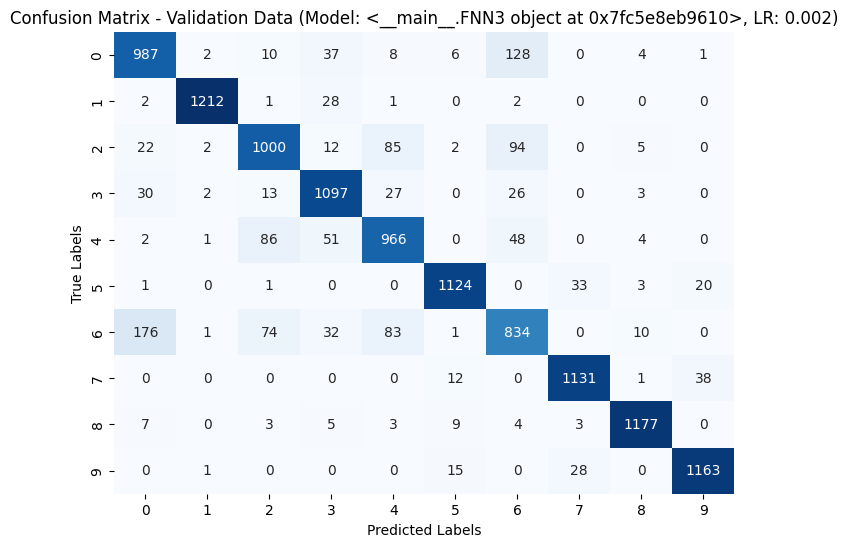

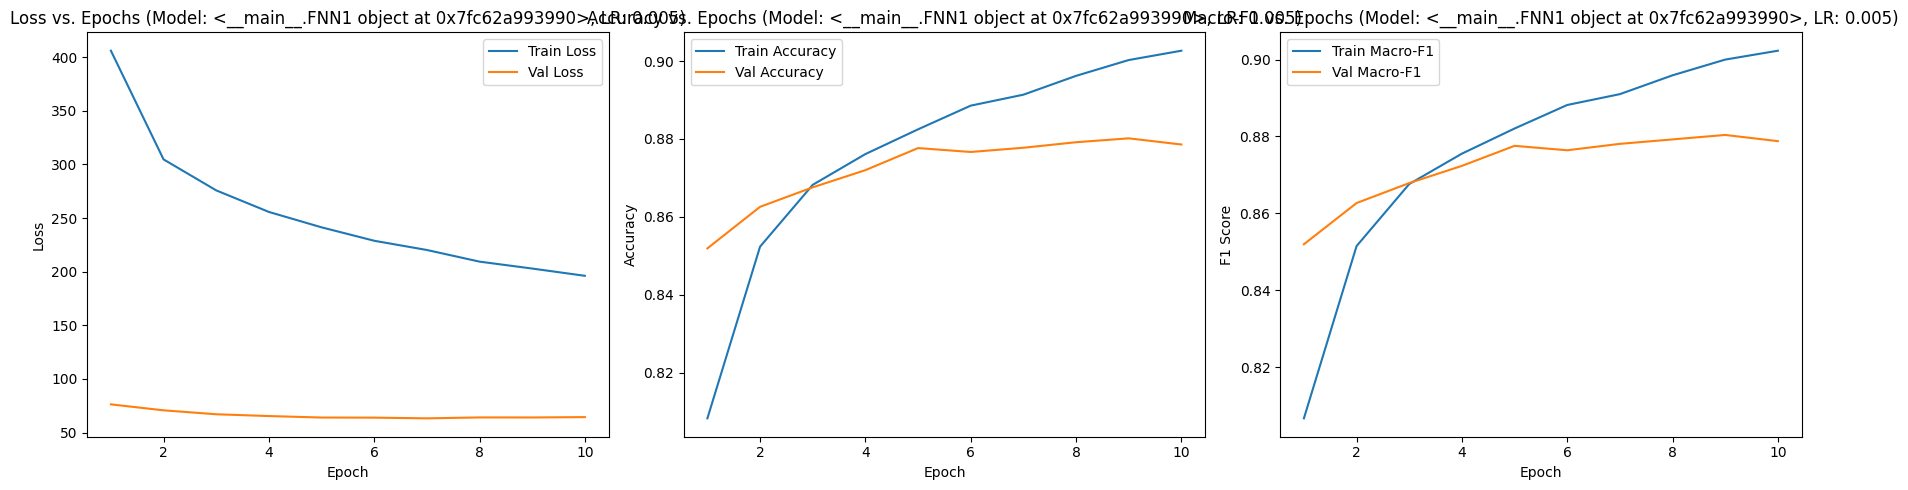

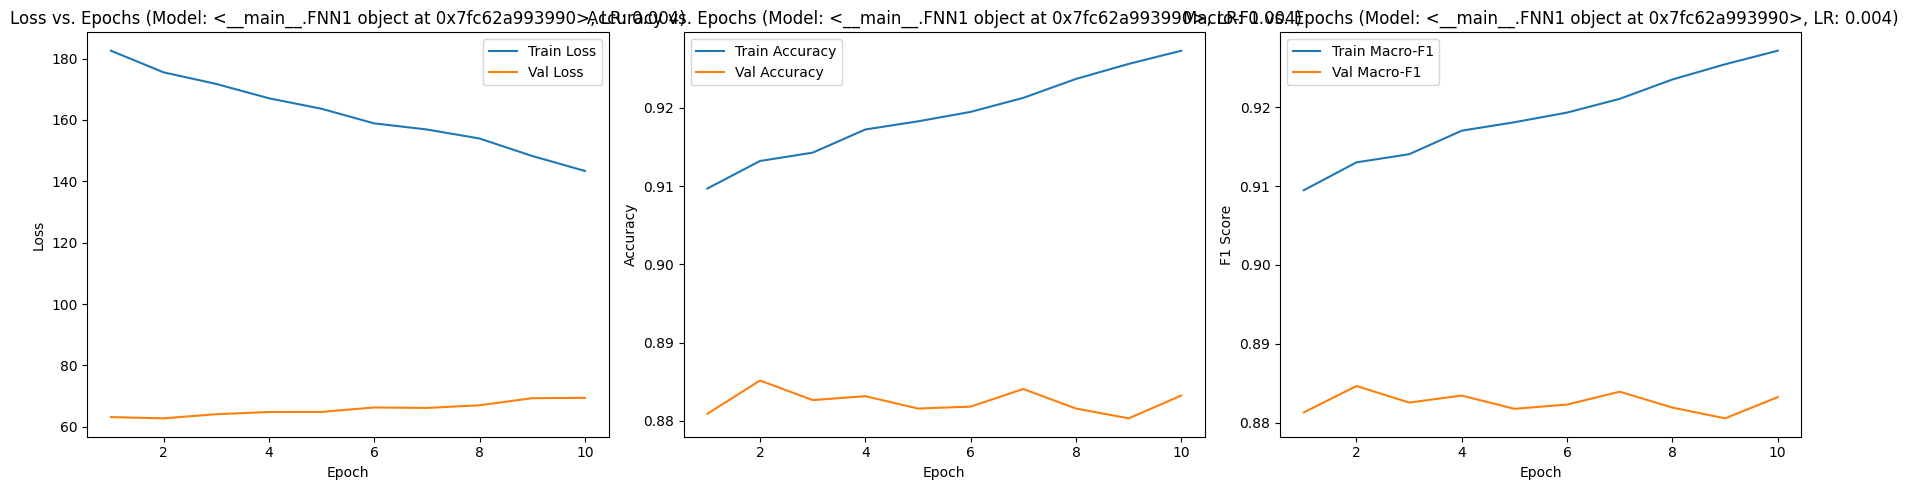

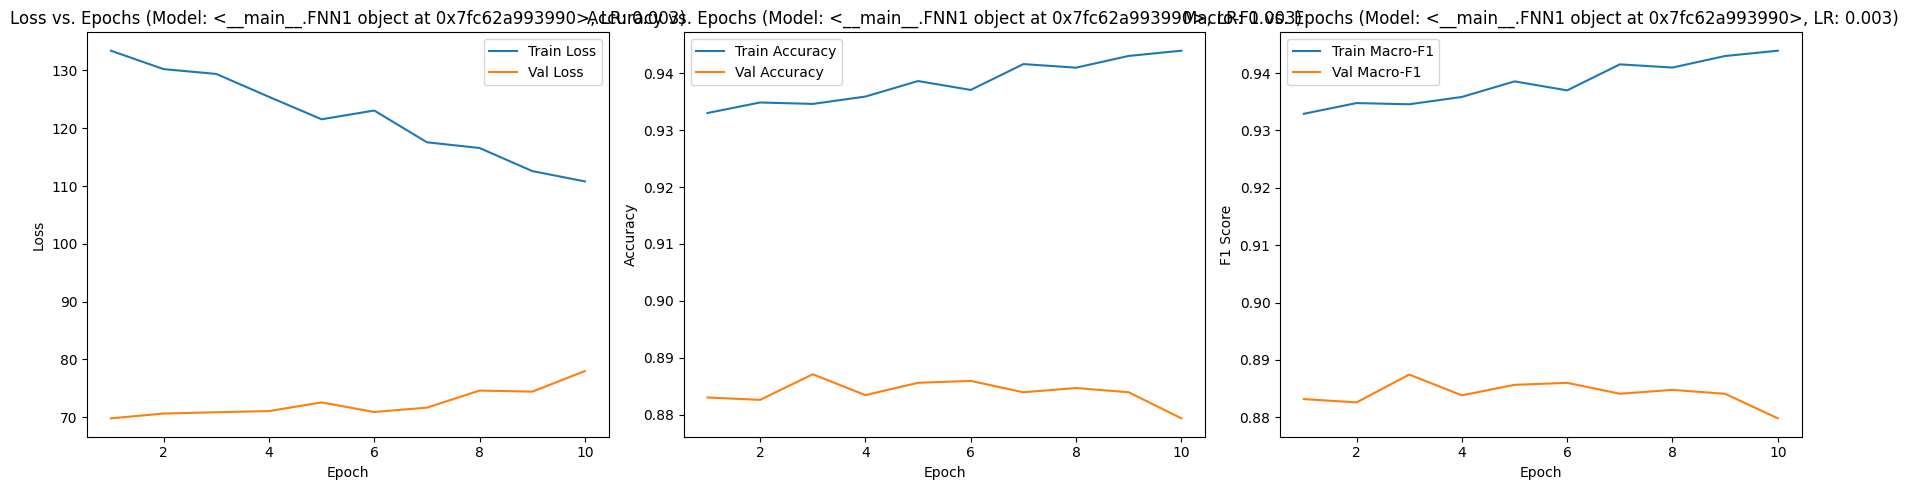

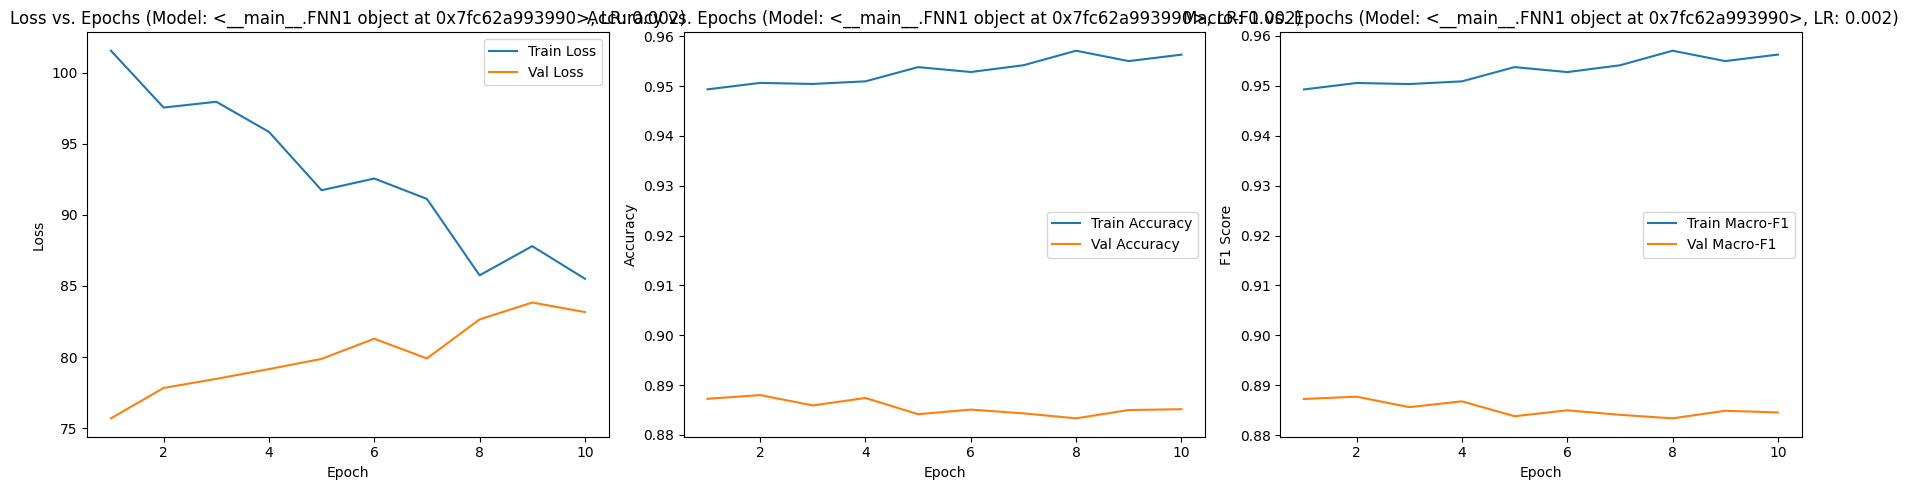

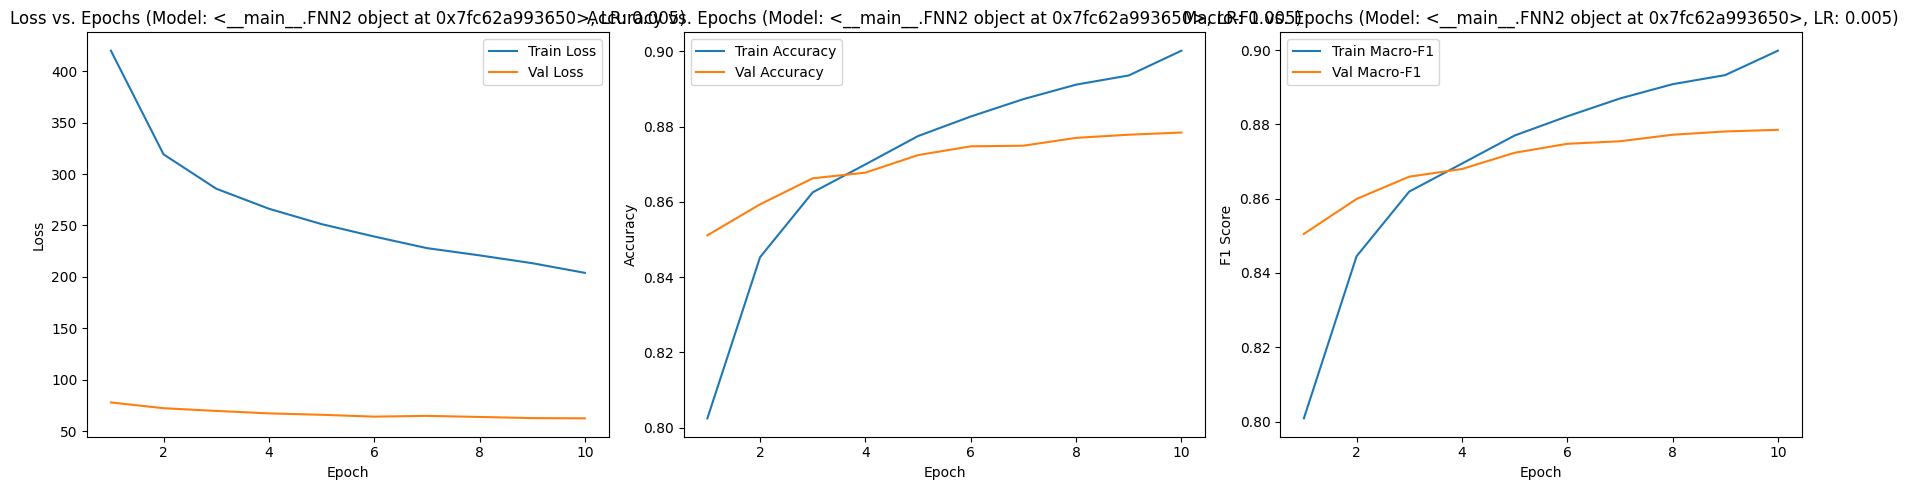

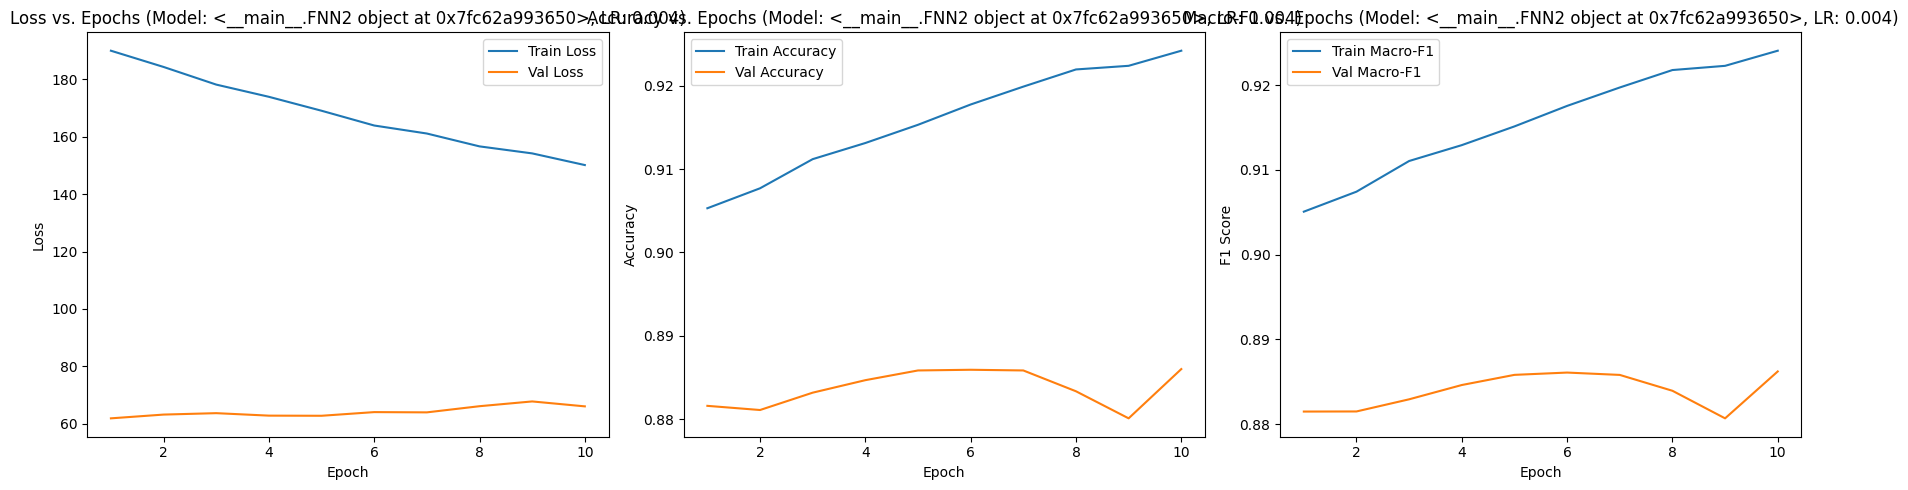

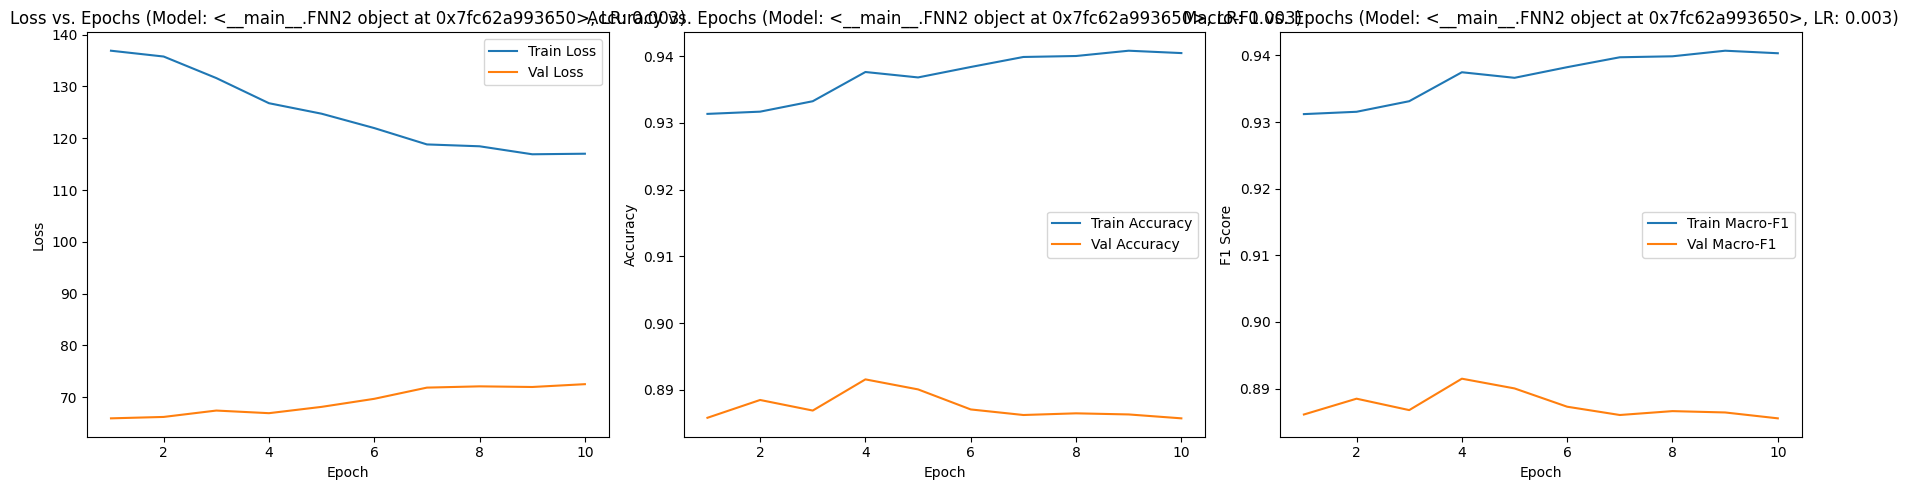

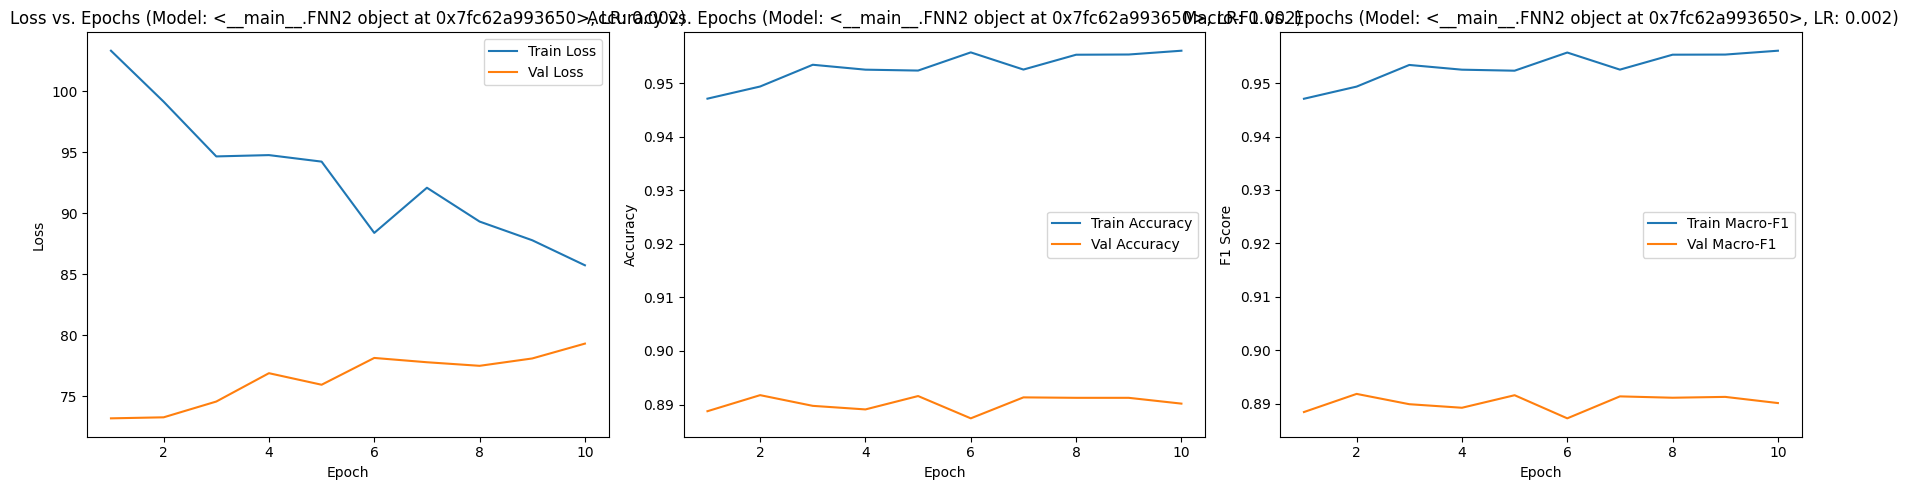

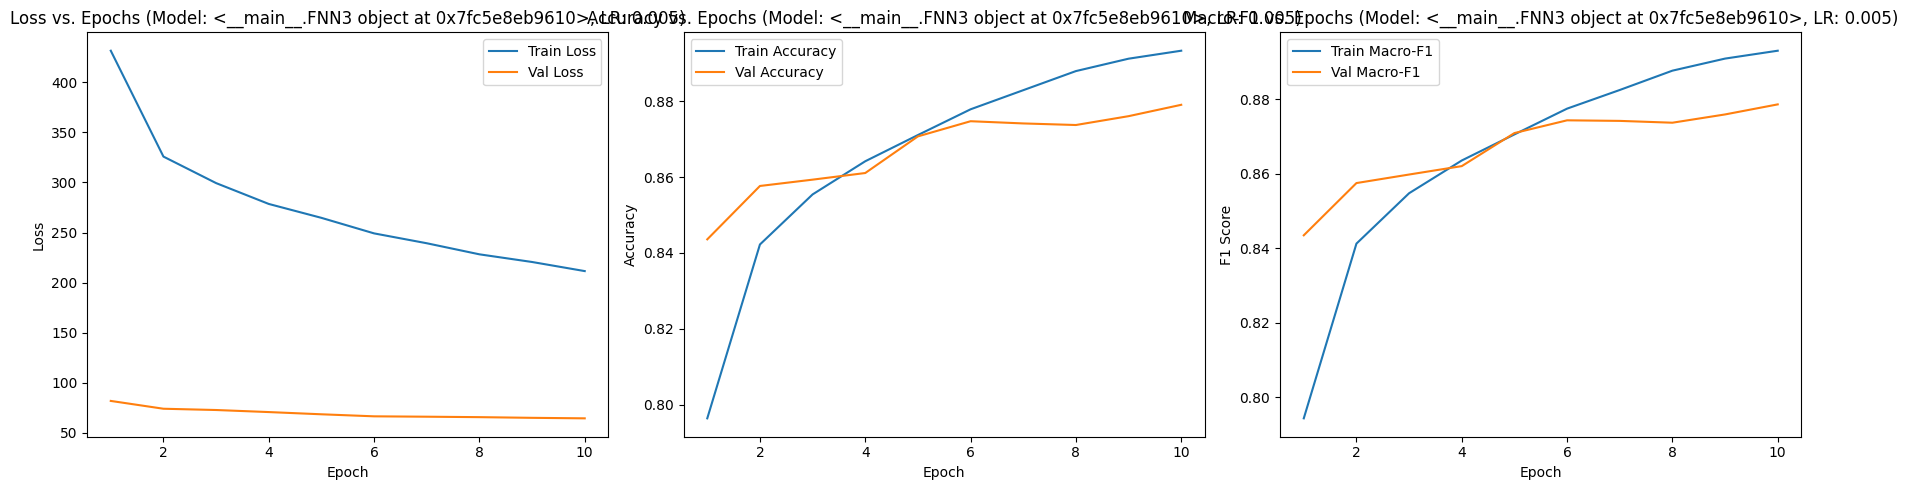

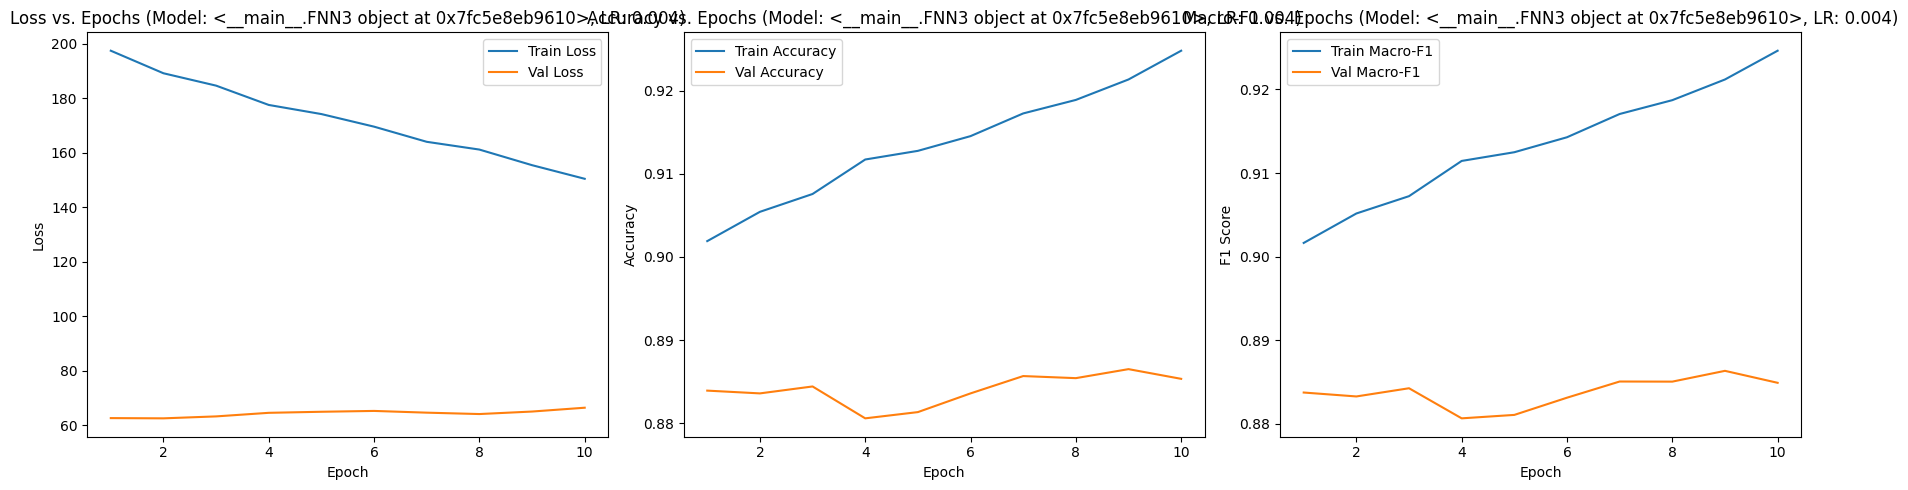

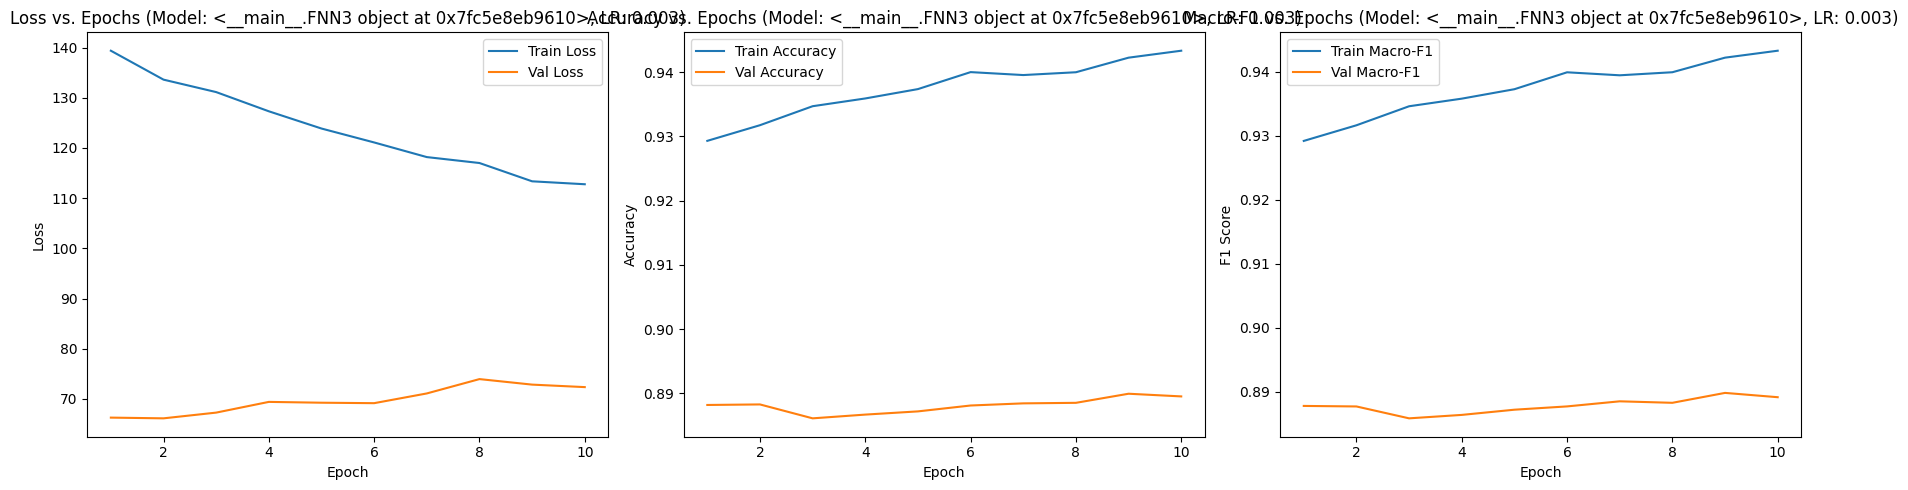

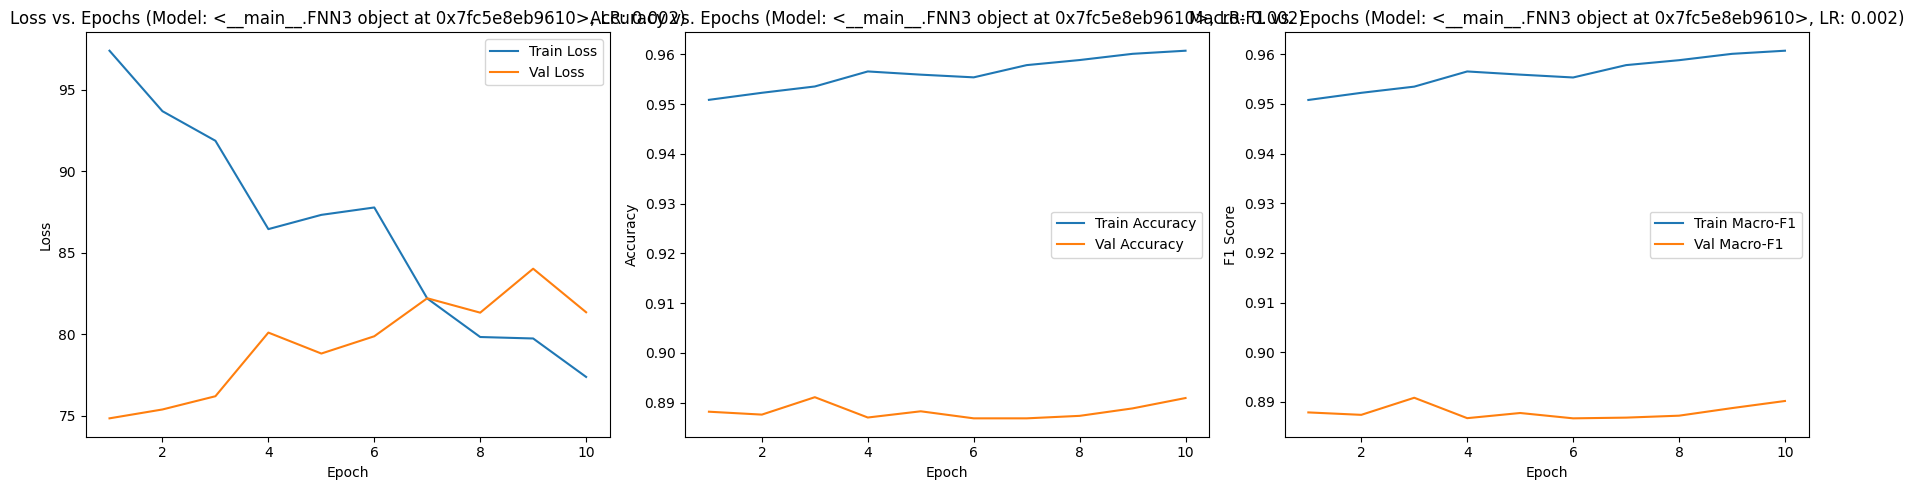

In [52]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle as pkl 

epochs = 10

models = [FNN1(), FNN2(), FNN3()]
alphas = [0.005, 0.004, 0.003, 0.002]

results = []

best_f1_val = 0

for model in models:
    for learning_rate in alphas:
        loss_fn = criterion
        train_losses = []
        train_accs = []
        train_f1s = []
        val_losses = []
        val_accs = []
        val_f1s = []
        for epoch in range(epochs):
        
            # Training loop
            model.train()
            train_epoch_loss = 0
            all_preds_train = []
            all_labels_train = []

            for X_batch, y_batch in train_loader:
                X_batch = X_batch.view(X_batch.size(0), -1).numpy() 
                y_batch_one_hot = np.eye(10)[y_batch.numpy()]  

                preds = model.forward(X_batch)
                loss = loss_fn(preds, y_batch_one_hot)
                train_epoch_loss += loss

                grad_output = preds - y_batch_one_hot  
                model.backward(grad_output, learning_rate)
                
                predictions = np.argmax(preds, axis=1)
                all_preds_train.append(predictions)
                all_labels_train.append(y_batch.numpy())
            
            all_preds_train = np.concatenate(all_preds_train)
            all_labels_train = np.concatenate(all_labels_train)

            avg_train_loss = train_epoch_loss / len(train_loader)
            train_acc = accuracy_score(all_labels_train, all_preds_train)
            train_f1 = f1_score(all_labels_train, all_preds_train, average="macro")

            # Validation loop
            model.eval()
            val_epoch_loss = 0
            all_preds_val = []
            all_labels_val = []

            for X_batch, y_batch in val_loader:
                X_batch = X_batch.view(X_batch.size(0), -1).numpy()  
                y_batch_one_hot = np.eye(10)[y_batch.numpy()]  
                preds = model.forward(X_batch)
                loss = loss_fn(preds, y_batch_one_hot)
                val_epoch_loss += loss

                predictions = np.argmax(preds, axis=1)
                all_preds_val.append(predictions)
                all_labels_val.append(y_batch.numpy())

            all_preds_val = np.concatenate(all_preds_val)
            all_labels_val = np.concatenate(all_labels_val)

            avg_val_loss = val_epoch_loss / len(val_loader)
            val_acc = accuracy_score(all_labels_val, all_preds_val) 
            val_f1 = f1_score(all_labels_val, all_preds_val, average="macro")

            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Training Macro-F1 Score: {train_f1:.4f}")
            print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, Validation Macro-F1 Score: {val_f1:.4f}")
            
            val_losses.append(val_epoch_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)
            train_losses.append(train_epoch_loss)
            train_accs.append(train_acc)
            train_f1s.append(train_f1)

        if val_f1 > best_f1_val:
            with open('model_1905084.pickle', 'wb') as file:  # 'wb' means write in binary mode
                pkl.dump(model, file)
                
        results.append({
            "model": model,
            "learning_rate": learning_rate,
            "train_losses": train_losses,
            "train_accs": train_accs,
            "train_f1s": train_f1s,
            "val_losses": val_losses,
            "val_accs": val_accs,
            "val_f1s": val_f1s
        })

        val_conf_matrix = confusion_matrix(all_labels_val, all_preds_val)
        plt.figure(figsize=(8, 6))
        sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix - Validation Data (Model: {model}, LR: {learning_rate})")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()

for result in results:
    model = result["model"]
    lr = result["learning_rate"]

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(1, epochs + 1), result["train_losses"], label="Train Loss")
    plt.plot(range(1, epochs + 1), result["val_losses"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss vs. Epochs (Model: {model}, LR: {lr})")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(range(1, epochs + 1), result["train_accs"], label="Train Accuracy")
    plt.plot(range(1, epochs + 1), result["val_accs"], label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy vs. Epochs (Model: {model}, LR: {lr})")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(range(1, epochs + 1), result["train_f1s"], label="Train Macro-F1")
    plt.plot(range(1, epochs + 1), result["val_f1s"], label="Val Macro-F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title(f"Macro-F1 vs. Epochs (Model: {model}, LR: {lr})")
    plt.legend()

    plt.tight_layout()
    plt.show()

Best model

In [53]:
# learning_rate = best_alpha
epochs = 15

with open('model_1905084.pickle', 'rb') as file:  # 'rb' means read in binary mode
    model = pkl.load(file)

test_loss = 0
all_preds_test = []
all_labels_test = []

for X_batch, y_batch in test_loader:
    X_batch = X_batch.view(X_batch.size(0), -1).numpy()  
    y_batch_one_hot = np.eye(10)[y_batch.numpy()]  # One-hot encoding of labels

    preds = model.forward(X_batch)
    loss = criterion(preds, y_batch_one_hot)
    test_loss += loss

    predictions = np.argmax(preds, axis=1)
    all_preds_test.append(predictions)
    all_labels_test.append(y_batch.numpy())

all_preds_test = np.concatenate(all_preds_test)
all_labels_test = np.concatenate(all_labels_test)

avg_test_loss = test_loss / len(test_loader)
test_acc = accuracy_score(all_labels_test, all_preds_test) 
test_f1 = f1_score(all_labels_test, all_preds_test, average="macro")

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Macro-F1 Score: {test_f1:.4f}")
 

Test Loss: 0.4815, Test Accuracy: 0.8832, Test Macro-F1 Score: 0.8831
